In [1]:
%matplotlib inline
import ast
import category_encoders as ce
import datetime
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import requests
import sklearn
import traceback
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/merged_datasets.csv')

# select features(variables) for analysis 

In [3]:
whitelist = [
    'director_gender',
    'director_popularity', 
    'primary_cast_gender',
    'primary_cast_popularity', 
    'secondary_cast_gender',
    'secondary_cast_popularity',
    'adult', 
    'budget', 
    'genres', 
    'original_language',
    'original_title', 
    'popularity', 
    'production_companies', 
    'production_countries', 
    'release_date', 
    'revenue', 
    'runtime', 
    'spoken_languages', 
    'status', 
    'title', 
    'video', 
    'vote_average', 
    'vote_count'
]
df = df[whitelist]

In [4]:
# filter out noisy data and only keep the boolean true and false value
df = df[(df.video == True) | (df.video == False)]
df.dropna(inplace=True)

## get first item from the embedded json list

In [5]:
def get_first_from(value):
    list_ = ast.literal_eval(value)
    return list_[0].get('name') if list_ else None

columns = ['genres', 'production_companies','production_countries','spoken_languages']
for c in columns:
    df[f'major_{c}'] = df[c].apply(get_first_from)
df.drop(columns=columns, axis=1, inplace=True)

## check if title has changed

In [6]:
df['title_changed'] = (df.original_title != df.title)
df.drop(columns=['original_title'], axis=1, inplace=True)

## convert categorical variables to numeric for data analysis

In [7]:
column = 'status'
df[column] = df[column].astype('category')
df[f'{column}_code'] = df[column].cat.codes
df.drop(columns=[column], axis=1, inplace=True)

## convert categorical variables to ordinal if there are many unique values

In [8]:
columns = [
    'original_language',
    'major_genres',
    'major_production_companies',
    'major_production_countries',
    'major_spoken_languages',
]
df[columns] = df[columns].fillna('nan')
for c in columns:
    df_by = df[[c, 'revenue']].groupby(by=c).mean()
    df_by.sort_values(by='revenue', inplace=True)
    df_by.reset_index(inplace=True)
    
    mapping = pd.Series(df_by.index.values, index=df_by[c]).to_dict()
    df.replace({c: mapping}, inplace=True)
    df[c] = df[c].astype(int)

## convert categorical variables to one-hot encoding if there are only a couple of unique values

In [9]:
columns = [
    'director_gender',
    'primary_cast_gender',
    'secondary_cast_gender',
    'status_code'
]
dfs = [df]
for c in columns:
    df_one_hot = pd.get_dummies(df[c], prefix=c)
    dfs.append(df_one_hot)
df = pd.concat(dfs, axis=1)
df.drop(columns=columns, axis=1, inplace=True)

## convert dates to numeric

In [10]:
df.release_date = pd.to_datetime(df.release_date)
epoch = datetime.date(1970, 1, 1)
df['release_date_epoch'] = df.release_date.apply(lambda x: (x.date() - epoch).days)
df.drop(columns=['release_date'], inplace=True)

## change datatypes

In [11]:
df.adult = df.adult.astype(int)
df.runtime = df.runtime.astype(int)
df.video = df.video.astype(int)
df.vote_count = df.vote_count.astype(int)
df.title_changed = df.title_changed.astype(int)

In [12]:
df.head()

,director_popularity,primary_cast_popularity,secondary_cast_popularity,adult,budget,original_language,popularity,revenue,runtime,title,...,secondary_cast_gender_1,secondary_cast_gender_2,secondary_cast_gender_3,status_code_0,status_code_1,status_code_2,status_code_3,status_code_4,status_code_5,release_date_epoch
0,4.430,18.883,5.016,0,30000000,72,21.946943,373554033.0,81,Toy Story,...,0,1,0,0,0,0,0,1,0,9433
1,4.032,10.278,1.370,0,65000000,72,17.015539,262797249.0,104,Jumanji,...,0,1,0,0,0,0,0,1,0,9479
2,1.083,5.380,4.775,0,0,72,11.712900,0.0,101,Grumpier Old Men,...,0,1,0,0,0,0,0,1,0,9486
3,3.893,2.608,4.735,0,16000000,72,3.859495,81452156.0,127,Waiting to Exhale,...,1,0,0,0,0,0,0,1,0,9486
4,1.056,3.292,7.819,0,0,72,8.387519,76578911.0,106,Father of the Bride Part II,...,1,0,0,0,0,0,0,1,0,9171


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34847 entries, 0 to 34980
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   director_popularity         34847 non-null  float64
 1   primary_cast_popularity     34847 non-null  float64
 2   secondary_cast_popularity   34847 non-null  float64
 3   adult                       34847 non-null  int32  
 4   budget                      34847 non-null  int64  
 5   original_language           34847 non-null  int32  
 6   popularity                  34847 non-null  float64
 7   revenue                     34847 non-null  float64
 8   runtime                     34847 non-null  int32  
 9   title                       34847 non-null  object 
 10  video                       34847 non-null  int32  
 11  vote_average                34847 non-null  float64
 12  vote_count                  34847 non-null  int32  
 13  major_genres                348

In [14]:
for c in df:
    print(f'{c} = {len(df[c].unique())}')

director_popularity = 1678
primary_cast_popularity = 3945
secondary_cast_popularity = 4192
adult = 2
budget = 1078
original_language = 73
popularity = 34166
revenue = 6509
runtime = 308
title = 32456
video = 2
vote_average = 89
vote_count = 1805
major_genres = 21
major_production_companies = 8441
major_production_countries = 128
major_spoken_languages = 69
title_changed = 2
director_gender_0 = 2
director_gender_1 = 2
director_gender_2 = 2
director_gender_3 = 2
primary_cast_gender_0 = 2
primary_cast_gender_1 = 2
primary_cast_gender_2 = 2
primary_cast_gender_3 = 2
secondary_cast_gender_0 = 2
secondary_cast_gender_1 = 2
secondary_cast_gender_2 = 2
secondary_cast_gender_3 = 2
status_code_0 = 2
status_code_1 = 2
status_code_2 = 2
status_code_3 = 2
status_code_4 = 2
status_code_5 = 2
release_date_epoch = 15564


In [15]:
# df.to_csv('../data/feature_selection_2.csv')

# data exploration 
### To customize the layout, variables will be displayed by three plots. 
#### From the below plot we can see, there tends to show an linear trend between revenue and budget. At the same time, values of variables such as director_popularity, primary_cast_popularity, secondary_cast_poluarity and popularity tend to get slanted to the left(these variables are right-skewed), which gives us some hints that we can do some log transformation for further exploration to see if there's any relationship between these varaibles and revenue. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000273807E2248>,
      dtype=object)

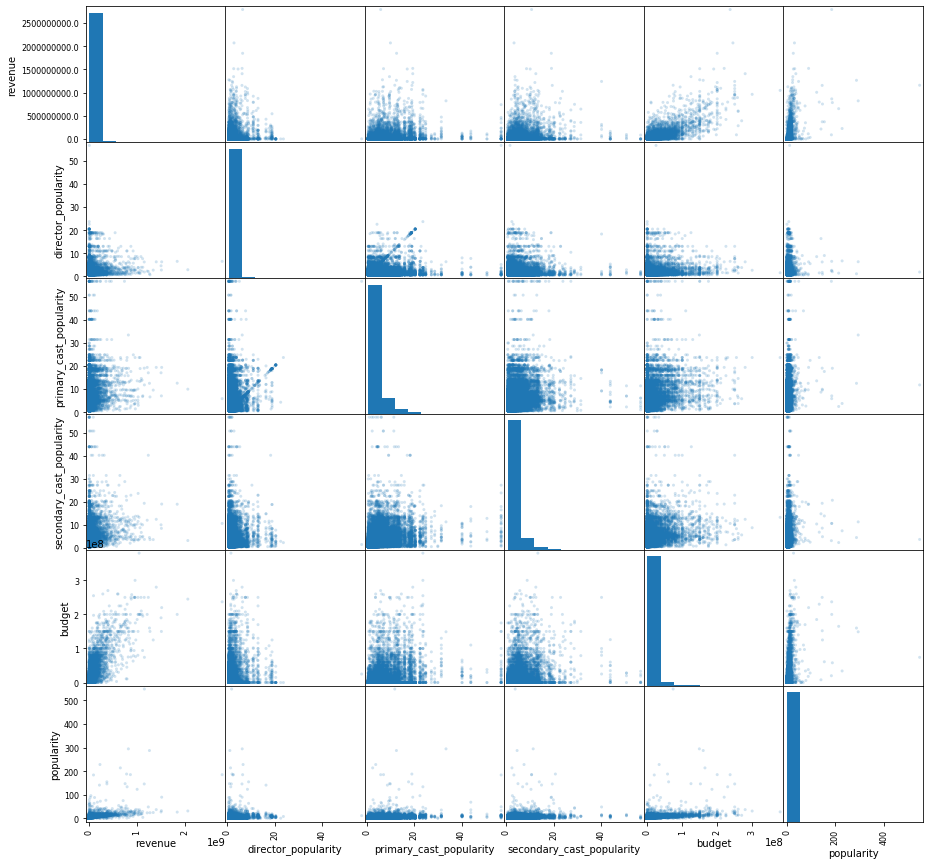

In [16]:
df1 = df[[
    'revenue',
    'director_popularity',
    'primary_cast_popularity',
    'secondary_cast_popularity',
    'budget',
    'popularity',
]]
pd.plotting.scatter_matrix(df1, alpha=0.2, figsize=(15, 15))

#### From the below plot we can see a linear regression trend shows between revenue and vote_count. Values of runtime tend to focus on the left side(right-skewed), which we can also do log transformation to further explore the relaitonship between revenue and runtime. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000273FF79A8C8>,
      dtype=object)

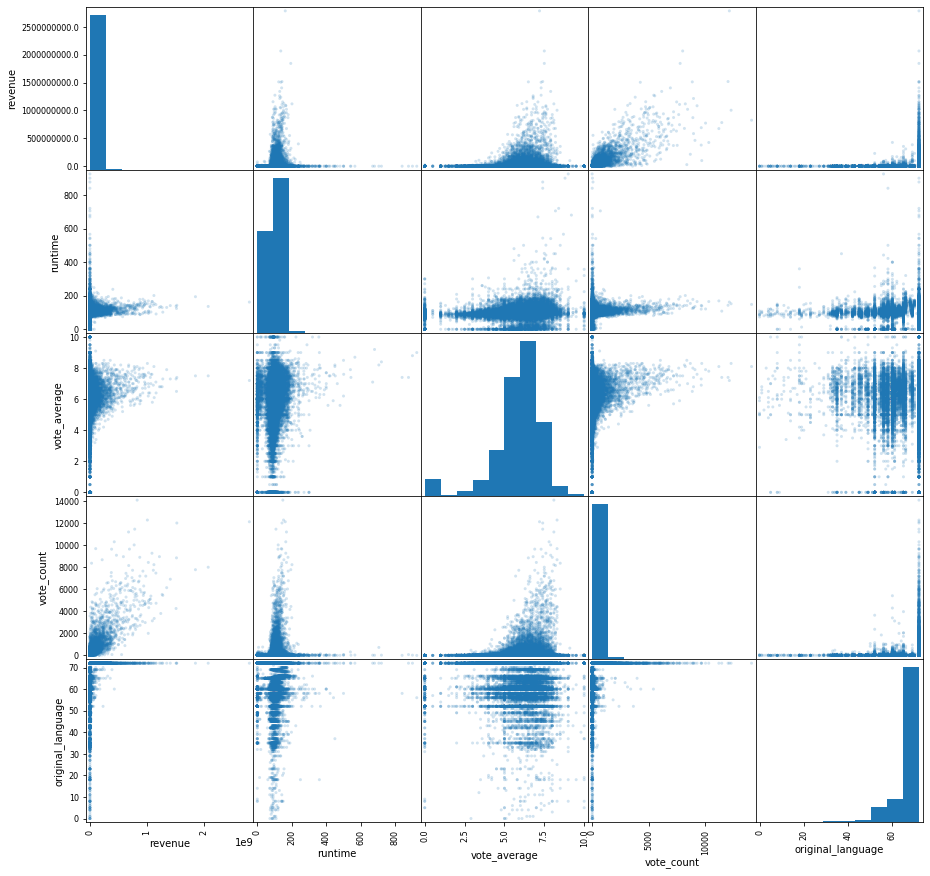

In [17]:
df2 = df[[
    'revenue',
    'runtime',
    'vote_average',
    'vote_count',
    'original_language'
]]
pd.plotting.scatter_matrix(df2, alpha=0.2, figsize=(15, 15))

#### We'll take log of the following variables to explore further since we can not see any obvious regression trend at this moment

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027387C48148>,
      dtype=object)

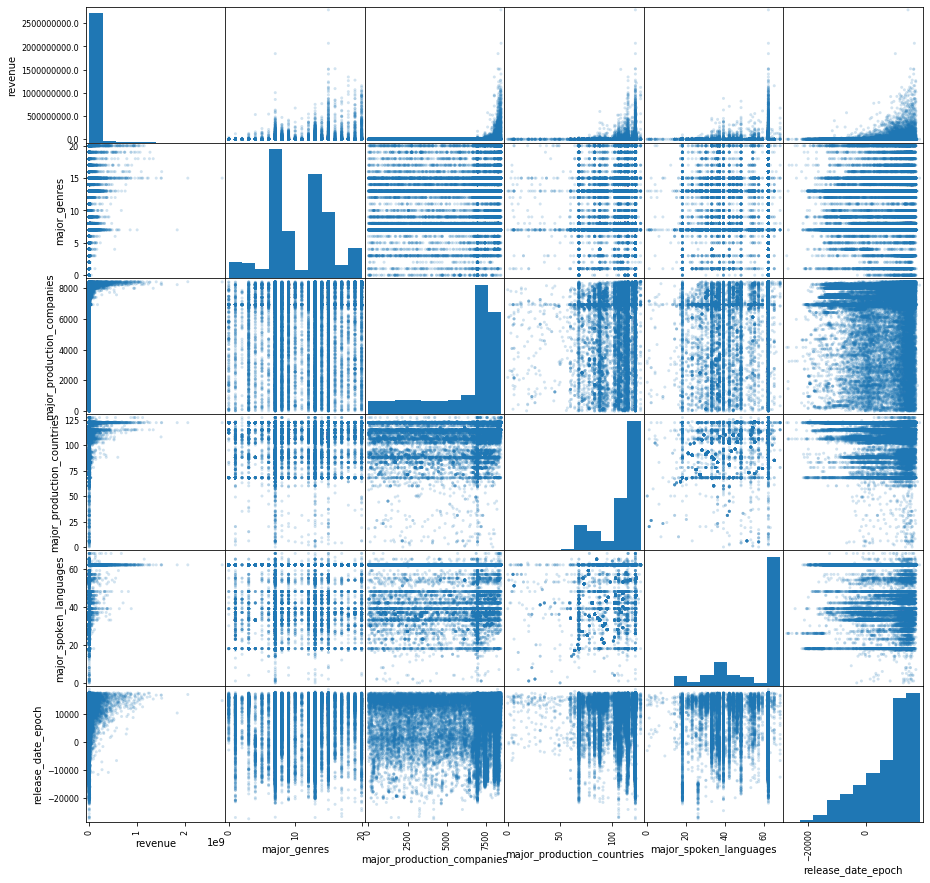

In [18]:
df3 = df[[
    'revenue',
    'major_genres',
    'major_production_companies',
    'major_production_countries',
    'major_spoken_languages',
    'release_date_epoch'
]]
pd.plotting.scatter_matrix(df3, alpha=0.2, figsize=(15, 15))

## log transformation

### If the variable is right-skewed, take their log.
#### After taking log, we can see some varaibles that seems unconnected with revenue before tend to show some regression trend, such as'director_popularity', 'primary_cast_popularity','secondary_cast_popularity','budget', 'popularity', and etc. We'll use the algorithm models to prove our assumption. 

In [19]:
columns = [
    'revenue',
    'director_popularity',
    'primary_cast_popularity',
    'secondary_cast_popularity',
    'budget',
    'popularity',
    'runtime',
    'vote_count',
]
for c in columns:
    df[c] = np.log10(df[c]+1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000273808CB448>,
      dtype=object)

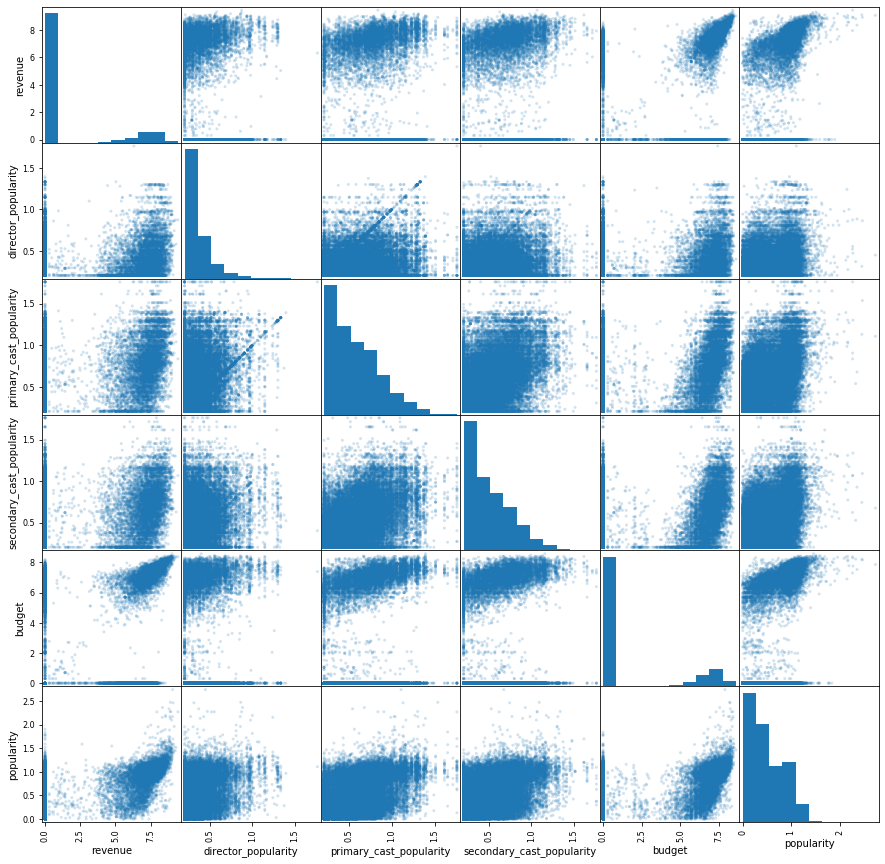

In [20]:
df1 = df[[
    'revenue',
    'director_popularity',
    'primary_cast_popularity',
    'secondary_cast_popularity',
    'budget',
    'popularity',
]]
pd.plotting.scatter_matrix(df1, alpha=0.2, figsize=(15, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002738BC8C908>,
      dtype=object)

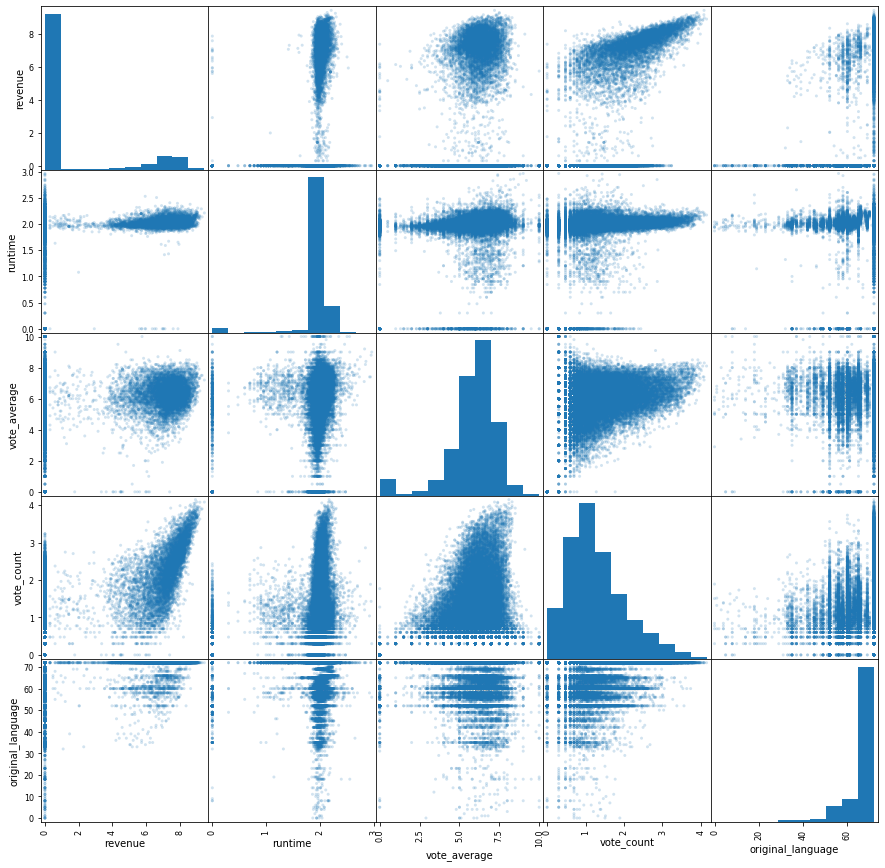

In [21]:
df2 = df[[
    'revenue',
    'runtime',
    'vote_average',
    'vote_count',
    'original_language'
]]
pd.plotting.scatter_matrix(df2, alpha=0.2, figsize=(15, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002738CE0CBC8>,
      dtype=object)

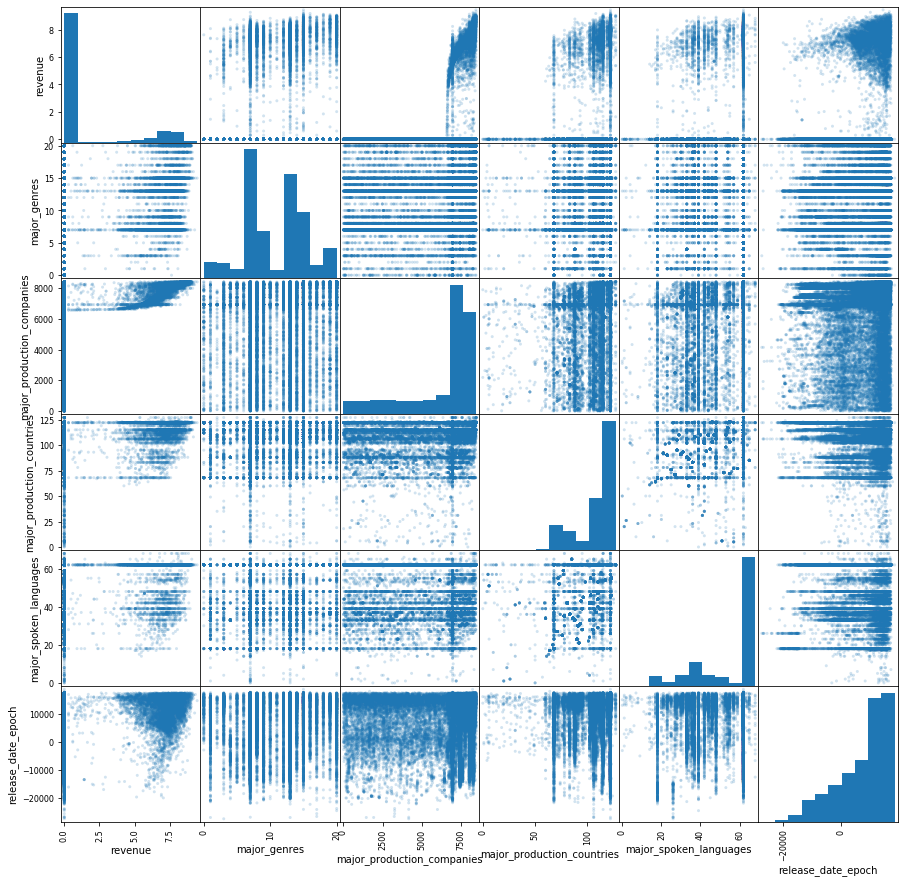

In [22]:
df3 = df[[
    'revenue',
    'major_genres',
    'major_production_companies',
    'major_production_countries',
    'major_spoken_languages',
    'release_date_epoch'
]]
pd.plotting.scatter_matrix(df3, alpha=0.2, figsize=(15, 15))

# regression

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
columns = df.columns
columns = [c for c in columns if c not in {'revenue', 'title'}]
X = df[columns]
y = df.revenue

In [25]:
reg = LinearRegression()
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
reg.score(X, y)

0.5859667216870238

In [27]:
reg.coef_

array([ 3.20500575e-01,  3.72993004e-01,  4.58582166e-01, -1.12834618e+00,
        3.72148380e-01, -1.68340496e-03, -3.29015295e-01,  1.28314145e-01,
       -4.25983514e-01, -8.94983736e-02,  1.54444220e+00, -7.05174129e-03,
        2.11950560e-04,  2.40784503e-03, -4.07126039e-03, -9.36187124e-02,
        2.04681343e-01,  2.68807158e-01,  2.26314353e-01, -6.99802854e-01,
        1.31094537e-01, -7.54266907e-02, -3.07767277e-02, -2.48911185e-02,
        2.02837927e-01,  2.60938527e-03, -5.43998370e-03, -2.00007329e-01,
        3.60622321e-01, -7.22031814e-01, -1.16693209e-01,  1.15990254e-02,
        1.94757095e-01,  2.71746581e-01, -3.58794433e-06])

In [28]:
import statsmodels.api as sm

In [29]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

In [30]:
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     1589.
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        12:07:37   Log-Likelihood:                -70737.
No. Observations:               34847   AIC:                         1.415e+05
Df Residuals:                   34815   BIC:                         1.418e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.4623      0.295     -4.962      0.000      -2.040      -0.885
director_popularity            0.3205      0.066      4.872      0.000       0.192       0.449
primary_cast_popularity        0.3730      0.044      8.392      0.000       0.286       0.460
secondary_cast_popularity      0.4586      0.048      9.573      0.000       0.365       0.552
adult                         -1.1283      0.922     -1.224      0.221      -2.935       0.678
budget                         0.3721      0.004     84.764      0.000       0.364       0.381
original_language             -0.0017      0.002     -1.044      0.296      -0.005       0.001
popularity                    -0.3290      0.062     -5.343      0.000      -0.450      -0.208
runtime                        0.1283      0.032      4.023      0.000       0.066       0.191
video                         -0.4260      0.393     -1.083      0.279      -1.197       0.345
vote_average                  -0.0895      0.007    -12.885      0.000      -0.103      -0.076
vote_count                     1.5444      0.032     48.394      0.000       1.482       1.607
major_genres                  -0.0071      0.002     -3.139      0.002      -0.011      -0.003
major_production_companies     0.0002   4.69e-06     45.229      0.000       0.000       0.000
major_production_countries     0.0024      0.001      3.674      0.000       0.001       0.004
major_spoken_languages        -0.0041      0.001     -4.347      0.000      -0.006      -0.002
title_changed                 -0.0936      0.031     -3.028      0.002      -0.154      -0.033
director_gender_0             -0.1609      0.291     -0.554      0.580      -0.730       0.409
director_gender_1             -0.0968      0.292     -0.332      0.740      -0.668       0.475
director_gender_2             -0.1393      0.290     -0.480      0.631      -0.708       0.429
director_gender_3             -1.0654      1.022     -1.042      0.297      -3.069       0.938
primary_cast_gender_0         -0.2345      0.133     -1.764      0.078      -0.495       0.026
primary_cast_gender_1         -0.4410      0.130     -3.386      0.001      -0.696      -0.186
primary_cast_gender_2         -0.3964      0.130     -3.049      0.002      -0.651      -0.142
primary_cast_gender_3         -0.3905      0.393     -0.994      0.320      -1.160       0.379
secondary_cast_gender_0       -0.1627      0.160     -1.014      0.311      -0.477       0.152
secondary_cast_gender_1       -0.3630      0.159     -2.283      0.022      -0.675      -0.051
secondary_cast_gender_2       -0.3710      0.159     -2.336      0.020      -0.682      -0.060
secondary_cast_gender_3       -0.5656      0.515     -1.098      0.272      -1.576       0.444
status_code_0                  0.1169      

## drop any feature if the corresponding p-value > 0.05

In [63]:
dropped = {
    'adult',
    'original_language',
    'video',
    'director_gender_0',
    'director_gender_1',
    'director_gender_2',
    'director_gender_3',
    'primary_cast_gender_0',
    'primary_cast_gender_3',
    'secondary_cast_gender_0',
    'secondary_cast_gender_3',
    'status_code_0',
    'status_code_1',
    'status_code_2',
    'status_code_3',
    'status_code_4',
    'status_code_5'
}
columns = [c for c in columns if c not in dropped]
X = df[columns]

In [32]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

In [33]:
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     2737.
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        12:12:25   Log-Likelihood:                -70742.
No. Observations:               34847   AIC:                         1.415e+05
Df Residuals:                   34828   BIC:                         1.417e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.1545      0.103    -20.972      0.000      -2.356      -1.953
director_popularity            0.3246      0.065      5.004      0.000       0.197       0.452
primary_cast_popularity        0.3706      0.044      8.363      0.000       0.284       0.458
secondary_cast_popularity      0.4557      0.048      9.536      0.000       0.362       0.549
budget                         0.3723      0.004     84.846      0.000       0.364       0.381
popularity                    -0.3293      0.062     -5.351      0.000      -0.450      -0.209
runtime                        0.1276      0.032      4.019      0.000       0.065       0.190
vote_average                  -0.0887      0.007    -12.793      0.000      -0.102      -0.075
vote_count                     1.5461      0.032     48.543      0.000       1.484       1.608
major_genres                  -0.0072      0.002     -3.209      0.001      -0.012      -0.003
major_production_companies     0.0002   4.66e-06     45.410      0.000       0.000       0.000
major_production_countries     0.0023      0.001      3.595      0.000       0.001       0.004
major_spoken_languages        -0.0042      0.001     -4.592      0.000      -0.006      -0.002
title_changed                 -0.0788      0.028     -2.817      0.005      -0.134      -0.024
primary_cast_gender_1         -0.2008      0.046     -4.388      0.000      -0.290      -0.111
primary_cast_gender_2         -0.1595      0.044     -3.659      0.000      -0.245      -0.074
secondary_cast_gender_1       -0.1967      0.039     -5.017      0.000      -0.274      -0.120
secondary_cast_gender_2       -0.2060      0.038     -5.362      0.000      -0.281      -0.131
release_date_epoch         -3.701e-06   1.31e-06     -2.821      0.005   -6.27e-06   -1.13e-06
==============================================================================
Omnibus:                     2263.059   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6076.275
Skew:                           0.366   Prob(JB):                         0.00
Kurtosis:                       4.910   Cond. No.                     1.32e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
reg = LinearRegression()
reg.fit(X, y)
reg.score(X, y)

0.5858531309160093

In [61]:
{k: v for k, v in sorted(dict(zip(columns, reg.coef_)).items(), key=lambda item: abs(item[1]), reverse=True)}

{'vote_count': 1.5460560539117367,
 'secondary_cast_popularity': 0.45574367817089434,
 'budget': 0.37231736321818604,
 'primary_cast_popularity': 0.37063948884525166,
 'popularity': -0.3293039343535821,
 'director_popularity': 0.3245888717271711,
 'secondary_cast_gender_2': -0.2059916233496588,
 'primary_cast_gender_1': -0.20075017002011733,
 'secondary_cast_gender_1': -0.1966866449526486,
 'primary_cast_gender_2': -0.15951804974892353,
 'runtime': 0.12763230513365215,
 'vote_average': -0.08867323959899803,
 'title_changed': -0.07877834275040853,
 'major_genres': -0.00720163537753742,
 'major_spoken_languages': -0.004249050339815735,
 'major_production_countries': 0.0023239141646881675,
 'major_production_companies': 0.0002116709884253756,
 'release_date_epoch': -3.7007621482432345e-06}

In [52]:
from sklearn.linear_model import LassoCV
lassocv = LassoCV(cv = 10, max_iter = 100000, normalize = True, random_state=42)
lassocv.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=False)

In [53]:
lassocv.score(X, y)

0.5858260557446044

In [62]:
{k: v for k, v in sorted(dict(zip(columns, lassocv.coef_)).items(), key=lambda item: abs(item[1]), reverse=True)}

{'vote_count': 1.5223514072065891,
 'secondary_cast_popularity': 0.43908849452501564,
 'budget': 0.3725155969748229,
 'primary_cast_popularity': 0.3551870858415699,
 'director_popularity': 0.3207689801434804,
 'popularity': -0.28050436821249186,
 'secondary_cast_gender_2': -0.18552825404384635,
 'secondary_cast_gender_1': -0.17518863579771696,
 'primary_cast_gender_1': -0.1734908481087803,
 'primary_cast_gender_2': -0.13356264238417082,
 'runtime': 0.11916628583482919,
 'vote_average': -0.08586139633843012,
 'title_changed': -0.07397874195183235,
 'major_genres': -0.006745779044470075,
 'major_spoken_languages': -0.003839726734148249,
 'major_production_countries': 0.002121570838211089,
 'major_production_companies': 0.00021114655347124553,
 'release_date_epoch': -3.2101982486385826e-06}

In [78]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X, y)
{k: v for k, v in sorted(dict(zip(columns, lasso.coef_)).items(), key=lambda item: abs(item[1]), reverse=True)}

{'vote_count': 1.1242366611967427,
 'budget': 0.41102090974889555,
 'major_production_countries': 0.005169432110707727,
 'major_production_companies': 0.00023872325195255556,
 'release_date_epoch': 6.105600169046871e-06,
 'director_popularity': 0.0,
 'primary_cast_popularity': 0.0,
 'secondary_cast_popularity': 0.0,
 'popularity': 0.0,
 'runtime': 0.0,
 'vote_average': -0.0,
 'major_genres': 0.0,
 'major_spoken_languages': 0.0,
 'title_changed': -0.0,
 'primary_cast_gender_1': -0.0,
 'primary_cast_gender_2': 0.0,
 'secondary_cast_gender_1': 0.0,
 'secondary_cast_gender_2': -0.0}

In [79]:
lasso.score(X, y)

0.5766014452360817